<a href="https://colab.research.google.com/github/jiwoong2/deeplearning/blob/main/PCA_color_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA color augmentation

PCA color augmentation은 ImageNet Classification with Deep Convolutional
Neural Networks(AlexNet)논문에 제시된 data augmentation 기법으로 이 프로젝트를 통해 PCA color augmentation의 아이디어를 이해하고, 파이썬 코드로 구현해 보고자 한다.

# PCA color augmentation의 대략적인 과정과 아이디어

ImageNet Classification with Deep Convolutional Neural Networks 논문에서 설명하는 PCA color augmentation의 과정은 다음과 같다.

1. 이미지의 R,G,B값에 대한 covariance matrix(공분산 행렬)을 구한다.

2. 위에서 구한 covariance matrix 의 고윳값과 고유벡터를 구한다.

3. 고윳값에 평균이 0이고 표준편차가 0.1인 가우시안분포를 기반으로 생성한 각기 다른 random variable $ \alpha $를 곱해준다.

4. 각 열을 고유벡터로 갖는 행렬 $[\textbf{p}_1, \textbf{p}_2, \textbf{p}_3]$과 그에 상응하는 고유값이 순서대로 나열된(위의 $ \alpha $이 곱해진)벡터 [$\lambda_1 \alpha_1, \lambda_2 \alpha_2, \lambda_3 \alpha_3$]를 dot product한다.

5. 위에서 구한 3차원 벡터를 각 픽셀의 RGB값에 더해준다.

과정을 살펴보면 이미지의 RGB값을 이용해 구한 covarian matrix의 고윳값과 고유벡터를 사용해 원본이미지의 RGB값에 변화를 준다. 이미지의 RGB값의 분포특성을 반영한 covarian matirx의 **고유벡터와 그에 상응하는 고윳값을 곱함으로써 본래의
RGB 분포특성을 어느정도 유지면서 고윳값에 적당한 상수를 곱하는 방식으로 약간의 무작위한 분포차이를 만들어냄을 알 수 있다.**


*추가
결과를 확인해보면 주로 이미지의 밝기가 조정돼는듯 보인다.

# 각 과정에 대한 코드구현과 추가이해

이미지 불러오기

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
img = cv2.imread('/content/drive/MyDrive/워 해머-스페이스 마린.png', cv2.IMREAD_COLOR)

In [ ]:
cv2_imshow(img)
plt.imshow(img[:,:,::-1])

In [ ]:
print(img.shape)
print(img.dtype)

(515, 609, 3)
uint8


In [ ]:
# cv2로 불로온 컬러이미지의 색상 채널 순서는 BGR이다.
img_r = img.copy()
img_r[:,:,0] = 0
img_r[:,:,1] = 0
cv2_imshow(img_r)

이미지 RGB값 normalization

이미지의 픽셀값을 normalization하는 이유는 후에 이를 기반으로한 상관계수 행렬을 구하기 위함이다. covariance matirx는 data scale에 영향을 받아 그 값이 data scale에 따라 널뛰므로 부호를 통해 data 요소간의 상관 관계의 방향을 파악할 수는 있어도 값의 크기에서 의미를 찾기 힘들다. 하지만 이를보완한 상관계수는 normalization 과정을 거친 data를 사용하기 때문에 data scale에 영향을 받지 않고 data의 상관관계의 방향은 물론 그 강도까지 파악할 수 있다.

In [ ]:
img_norm = img.copy()

In [ ]:
img_norm = img_norm.reshape(-1, 3)
img_norm.shape

(313635, 3)

In [ ]:
# 이미지의 각 채널의 평균값을 0으로 변환한다.
img_norm = img_norm - np.mean(img_norm, axis = 0)

In [ ]:
# 이미지의 각 채널의 표준편차를 1로 변환한다.
img_norm = img_norm / np.std(img_norm, axis = 0)

covariance mattrix 와 고윳값 고유벡터 구하기.

normalization 과정을 거친 이미지의 RGB값을 기반으로한 covariance matirx(즉, 상관계수 행렬) form은 다음과 같다.

C = $ \begin{pmatrix} Var(R) & Cov(R, G) & Cov(R, B) \\ Cov(G, R) & Var(G) & Cov(G, B) \\ Cov(B, R) & Cov(B, G) & Var(B) \end{pmatrix}$

그렇다면 covariance matirx의 고윳값과 고유벡터에는 어떤의미가 있을까?

covariance matirx의 form을 다시 살펴보면 가장먼저 symmetrix matrix임을 알 수 있다. symmetric matrix는 대각화 가능하며 고유값으로 real number를 가지므로 위의 수식을 구현하는데 무리가 없다.

또, 임의의 3차원 벡터를 곱해보면 기반이된 이미지의 R, G, B값의 분산과 서로의 공분산 특성을 반영해 벡터를 mapping시킨다는 특징도 알 수 있다. 그 의미는 covariance matrix의 고유값중 가장 큰값에 대응하는 고유벡터가 R, G ,B값의 분산을 가장 크게 갖는 축(주 축)이고, 그 다음 큰 고유값에 해당하는 고유벡터는 두번째로 큰 분산을 갖는 축(두번째 주 축), 세번째 고유값에 해당하는 고유벡터는 세번째 주축이라는 뜻 이다. PCA color augmentation은 이 주축에 적당히 작은 임의의 값을 곱해 다시 더해줌으로써 이미지의 R, G, B값의 전체적인 분산특성(아마도 이미지의 색조?)을 헤치지 않으면서도 분산특성이 다른 이미지를 생성하는것이 목적임을 알 수 있다.

In [ ]:
cov = np.cov(img_norm, rowvar = False) # rowvar가 True일시 row가 변수 column이 관측값으로 설정.
print(cov)

[[1.00000319 0.96319511 0.88622698]
 [0.96319511 1.00000319 0.96751773]
 [0.88622698 0.96751773 1.00000319]]


In [ ]:
eig_vals, eig_vecs = np.linalg.eigh(cov) # np.linalg.eigh() 함수는 실수 대칭행렬(또는 복소수 에미리미트 행렬)의 eigen value, eigen vector을 반환함.
                                              # eigen value만 반환하는 eigvalsh(), 정사각행렬에서 작동하는 eig(), eigh)()등도 있음.
print(eig_vals)  # 기본 오름차순으로 정렬됨.
print(eig_vecs)  # 열 벡터임.

[0.00772785 0.11383269 2.87844903]
[[ 0.39911344 -0.71697614 -0.57153625]
 [-0.80871359  0.01847317 -0.58791247]
 [ 0.4320773   0.6968529  -0.57245546]]


In [ ]:
# 내림차순으로 정렬
idx = np.argsort(-eig_vals)
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

print(eig_vals)
print(eig_vecs)

[2.87844903 0.11383269 0.00772785]
[[-0.57153625 -0.71697614  0.39911344]
 [-0.58791247  0.01847317 -0.80871359]
 [-0.57245546  0.6968529   0.4320773 ]]


평균이 0이고 표준편차가 0.1인 가우시안 분포에서 랜더한 값 $\alpha$ 3개를 추출한다.

In [ ]:
alphas = np.random.normal(0, 0.1, 3)
print(alphas)

[ 0.02263332 -0.01849583  0.12893685]


$[\textbf{p}_1, \textbf{p}_2, \textbf{p}_3] [\lambda_1 \alpha_1, \lambda_2 \alpha_2, \lambda_3 \alpha_3]^T$를 계산해 3차원 벡터를 얻는다. 논문에서는 이 값을 그대로 원본이미지의 R, G, B값에 더해준다고 나와있지만 구현에서는 rescale과정을 통해 픽셀값과의 scale 차이를 줄여서 좀더 유의미한 값으로 만들어준다.

In [ ]:
delta = np.dot(eig_vecs, alphas*eig_vals)
delta = (delta*255.).astype('int8')
print(delta.dtype)
print(delta)

int8
[-9 -9 -9]


위의 3차원 벡터를 각 픽셀의 RGB값에 더해준후 범위를 0~255로 rescale 해준다.

In [ ]:
arg_img = img.reshape(-1,3)
arg_img = arg_img + delta
arg_img = arg_img.reshape(515, 609, 3)
arg_img = np.clip(arg_img, 0, 255)

In [ ]:
cv2_imshow(arg_img)

위 과정을 함수로만들고 10개의 이미지 출력하기.

In [ ]:
def PCA_color_argumentation(img):

    img_norm = img.reshape(-1,3)
    img_norm = img_norm - np.mean(img_norm, axis = 0)
    img_norm = img_norm / np.std(img_norm, axis = 0)

    cov = np.cov(img_norm, rowvar = False)

    en, ev = np.linalg.eigh(cov)

    alphas = np.random.randn(3) * 0.1

    sv = np.dot(ev, en * alphas)
    sv = (sv * 255).astype('int8')

    img_out = img.reshape(-1,3) + sv
    img_out = img_out.reshape(img.shape)
    img_out = np.clip(img_out, 0, 255)

    return img_out

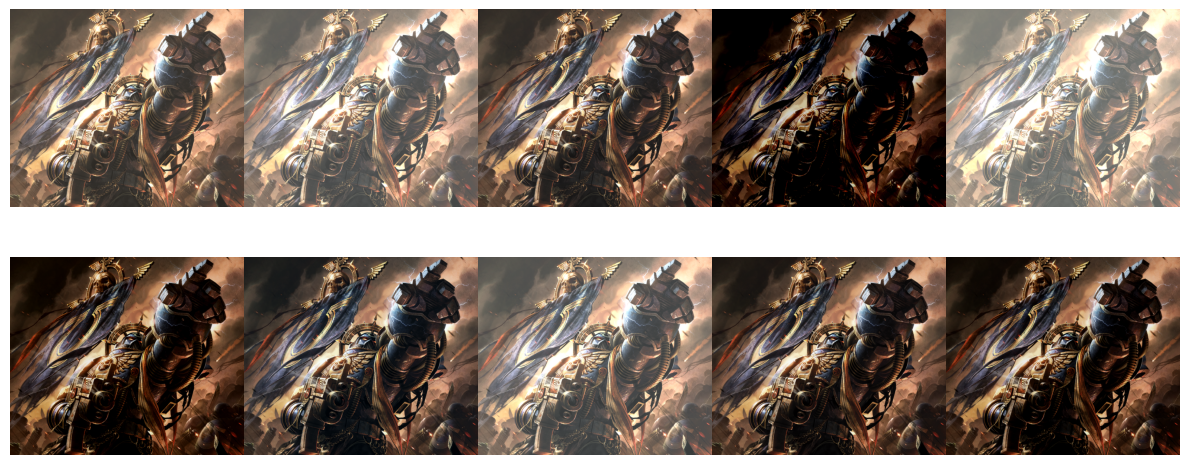

In [ ]:
plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(PCA_color_argumentation(img).astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.axis('off')


# plt.subplots_adjust(wspace = 0, hspace = 0)
plt.tight_layout(h_pad = 0, w_pad = 0)
plt.show()